In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training

### Imports

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import pprint
import math
import random
import sys
import os
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import cv2
import pickle

import tensorflow as tf

from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.metrics import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers

### Configurations

In [3]:
class Config:

	def __init__(self):

		self.verbose = True

		# Base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		self.im_size = 300

		# Image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# Number of ROIs at once
		self.num_rois = 4

		# Stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# Scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# Overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# Overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# Placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

### Parse the annotation file

In [4]:
def get_data(input_path):

	found_bg = False
	visualise = True

	all_imgs = {}
	classes_count = {}
	class_mapping = {}
	
	with open(input_path, 'r') as f:
		for line in f:
			line_split = line.strip().split(',')

			#	x1, y1, x2, y2 are the pixel value of the origial image
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename, x1, y1, x2, y2, class_name) = line_split
			filename = '/content/'+ filename

			if class_name not in classes_count:
				classes_count[class_name] = 0
			classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region.')
					found_bg = True

				class_mapping[class_name] = len(class_mapping)
    
			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows, cols) = img.shape[: 2]

				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})

		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping) - 1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

### ROI Pooling Convolutional Layer

In [5]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.

    # Arguments
        pool_size: int => Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img, X_roi] with shape:
        X_img: (1, rows, cols, channels)
        X_roi: (1,num_rois,4) => list of rois, with ordering (x, y, w, h)
    # Output shape
        3D tensor with shape: (1, num_rois, channels, pool_size, pool_size)'''

    def __init__(self, pool_size, num_rois, **kwargs):
        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]
        # x[1] is roi with shape (num_rois, 4) with ordering (x, y, w, h)
        rois = x[1]

        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):

            x, y, w, h = rois[0, roi_idx, 0], rois[0, roi_idx, 1], rois[0, roi_idx, 2], rois[0, roi_idx, 3]
            x, y, w, h = K.cast(x, 'int32'), K.cast(y, 'int32'), K.cast(w, 'int32'), K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y : y + h, x : x + w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                
        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'num_rois': self.num_rois
        }
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Base model => VGG 16 currently

In [6]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length // 16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):
    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (7, 7), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    for i in range(3):
      x = Conv2D(64, (1, 1), activation='relu', padding='same', name=f'block2_conv1_{i}')(x)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name=f'block2_conv2_{i}')(x)
      x = Conv2D(64, (1, 1), activation='relu', padding='same', name=f'block2_conv3_{i}')(x) 

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    for i in range(4):
      x = Conv2D(128, (1, 1), activation='relu', padding='same', name=f'block3_conv1_{i}')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name=f'block3_conv2_{i}')(x)
      x = Conv2D(512, (1, 1), activation='relu', padding='same', name=f'block3_conv3_{i}')(x) 

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    for i in range(6):
      x = Conv2D(256, (1, 1), activation='relu', padding='same', name=f'block4_conv1_{i}')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name=f'block4_conv2_{i}')(x)
      x = Conv2D(1024, (1, 1), activation='relu', padding='same', name=f'block4_conv3_{i}')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    for i in range(3):
      x = Conv2D(512, (1, 1), activation='relu', padding='same', name=f'block5_conv1_{i}')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name=f'block5_conv2_{i}')(x)
      x = Conv2D(512, (1, 1), activation='relu', padding='same', name=f'block5_conv3_{i}')(x)

    return x

###  RPN Layer

In [7]:
def rpn_layer(base_layers, num_anchors):
    """Create an rpn layer

        Step 1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step 2: Pass the step 1 output to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors * 4 (36 here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers 
        num_anchors

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: """

    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

###  Classifier Layer

In [8]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    Args:
        base_layers: base network being used
        input_rois: `(1,num_rois,4)` => list of rois, with ordering (x, y, w, h)
        num_rois: number of rois to be processed at a time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output"""

    input_shape = (num_rois, 7, 7, 512)
    pooling_regions = 7

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the conv. layer and conncet to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layers
    # out_class: softmax acivation function for classifying the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)

    # no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

### Calculate IoU (Intersection over Union)

In [9]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
  
	return area_union

def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y

	if w < 0 or h < 0:
		return 0

	return w * h

def iou(a, b):
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

### RPN for all Anchors of all Images

In [10]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""Args:
		C: config
		img_data: augmented image data
		width: original image width 
		height: original image height 
		resized_width: resized image width according to C.im_size 
		resized_height: resized image height according to C.im_size 
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4 * y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1, y1, x2, y2 => bounding boxes coordinates"""

	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   
	anchor_ratios = C.anchor_box_ratios  
	num_anchors = len(anchor_sizes) * len(anchor_ratios) 

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchor_ratios = len(anchor_ratios) 
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
 
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# RPN GT
	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchor_ratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for xi in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (xi + 0.5) - anchor_x / 2
				x2_anc = downscale * (xi + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for yj in range(output_height):
					# y-coordinates of the current anchor box
					y1_anc = downscale * (yj + 0.5) - anchor_y / 2
					y2_anc = downscale * (yj + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x, y) coord and the current anchor
					best_iou_for_curr = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
			 
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc) / 2.0
							cya = (y1_anc + y2_anc) / 2.0

							# x, y are the center point of ground-truth bbox
							# xa, ya are the center point of anchor bbox (xa = downscale * (ix + 0.5); ya = downscale * (iy + 0.5))
							# w, h are the width and height of ground-truth bbox
							# wa, ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [yj, xi, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1

								# we update the regression layer target if this IOU is the best for the current (x, y) and anchor position
								if curr_iou > best_iou_for_curr:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 1
						y_rpn_overlap[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 0

					elif bbox_type == 'neutral':
						y_is_box_valid[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 0
						y_rpn_overlap[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 0

					elif bbox_type == 'pos':
						y_is_box_valid[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 1
						y_rpn_overlap[yj, xi, anchor_ratio_idx + n_anchor_ratios * anchor_size_idx] = 1

						start = 4 * (anchor_ratio_idx + n_anchor_ratios * anchor_size_idx)
						y_rpn_regr[yj, xi, start : start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region
	for idx in range(num_anchors_for_bbox.shape[0]):

		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero 
			if best_anchor_for_bbox[idx, 0] == -1:
				continue

			y_is_box_valid[
				best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], best_anchor_for_bbox[idx, 2] + n_anchor_ratios *
				best_anchor_for_bbox[idx, 3]] = 1

			y_rpn_overlap[
				best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], best_anchor_for_bbox[idx, 2] + n_anchor_ratios *
				best_anchor_for_bbox[idx, 3]] = 1

			start = 4 * (best_anchor_for_bbox[idx, 2] + n_anchor_ratios * best_anchor_for_bbox[idx, 3])
	 
			y_rpn_regr[
				best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx,1], start : start + 4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	num_regions = 256

	if len(pos_locs[0]) > num_regions / 2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions / 2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions / 2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

### Image Size + Augmentation

In [11]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side

	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)
	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[: 2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0, 90, 180, 270], 1)[0]
			if angle == 270:
				img = np.transpose(img, (1, 0, 2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1, 0, 2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1, x2, y1, y2 = bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2']

				if angle == 270:
					bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2'] = y1, y2, cols - x2, cols - x1

				elif angle == 180:
					bbox['x2'], bbox['x1'], bbox['y2'], bbox['y1'] = cols - x1, cols - x2, rows - y1, rows - y2

				elif angle == 90:
					bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2']  = rows - y2, rows - y1, x1, x2
       
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]

	return img_data_aug, img

### Generate the Ground Truth Anchors

In [12]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode needs augmentation

	Returns:
		x_img: image data after resized and scaling
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug"""

	while True:
		for _, img_data in enumerate(all_img_data):
			try:
				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# preprocess image
				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1] // 2 :, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

### Define Loss Functions

In [13]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [14]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors
    Returns:
        Smooth L1 loss function => 0.5 * x * x (if x_abs < 1)
                                => x_abx - 0.5 (else)"""

    def rpn_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred
        x_abs = K.abs(x)

        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, : 4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, : 4 * num_anchors])

    return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors
        y_true[:, :, :, : 9] : [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid; contains pos or neg anchor
        y_true[:, :, :, 9 :] : [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid * y_pred, y_true))) / N"""

    def rpn_loss_cls_fixed_num(y_true, y_pred):
            return lambda_rpn_class * K.sum(y_true[:, :, :, : num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors :])) / K.sum(epsilon + y_true[:, :, :, : num_anchors])
    return rpn_loss_cls_fixed_num

def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors
    Returns:
        Smooth L1 loss function => 0.5 * x * x (if x_abs < 1)
                                => x_abx - 0.5 (otherwise)"""

    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4 * num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')

        return lambda_cls_regr * K.sum(
            y_true[:, :, : 4 * num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, : 4 * num_classes])
    
    return class_loss_regr_fixed_num

def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

### NMS

In [15]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300): 
    if len(boxes) == 0:
        return []

    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes are integers, convert them to floats
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain
    while len(idxs) > 0:

        # grab the last index in the indexes list and add the index value to the list of selected indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection
        xx1_int = np.maximum(x1[i], x1[idxs[: last]])
        yy1_int = np.maximum(y1[i], y1[idxs[: last]])
        xx2_int = np.minimum(x2[i], x2[idxs[: last]])
        yy2_int = np.minimum(y2[i], y2[idxs[: last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[: last]] - area_int

        # compute the ratio of overlap
        overlap = area_int / (area_union + 1e-6)

        idxs = np.delete(
            idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0]))
        )

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map
    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)
    Returns:
        X: regressed position and size for current anchor"""

    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w / 2.
        cy = y + h / 2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1 / 2.
        y1 = cy1 - h1 / 2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)

        return np.stack([x1, y1, w1, h1])
        
    except Exception as e:
        print(e)
        return X

### Apply Regression

In [16]:
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h

    try:
        cx = x + w/2.
        cy = y + h/2.

        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h

        x1 = cx1 - w1 / 2.
        y1 = cy1 - h1 / 2.

        x1, y1, w1, h1 = int(round(x1)), int(round(y1)), int(round(w1)), int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h

    except OverflowError:
        return x, y, w, h

    except Exception as e:
        print(e)
        return x, y, w, h

### Calculate IoUs

In [17]:
def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1, y1, x2, y2) to (x, y, w, h) format
    Args:
        R: bboxes, probs"""

    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width)) / C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width)) / C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height)) / C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height)) / C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] 

    for xi in range(R.shape[0]):
        (x1, y1, x2, y2) = R[xi, :]
        x1, y1, x2, y2 = int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

        best_iou = 0.0
        best_bbox = -1

        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue

        else:
            w = x2 - x1
            h = y2 - y1

            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                cls_name = 'bg'

            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))

            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1

        y_class_num.append(copy.deepcopy(class_label))

        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)

        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos : 4 + label_pos] = [sx * tx, sy * ty, sw * tw, sh * th]
            labels[label_pos : 4 + label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    X = np.array(x_roi)
    Y1 = np.array(y_class_num)
    Y2 = np.concatenate([np.array(y_class_regr_label), np.array(y_class_regr_coords)], axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

### RPN to ROI

In [18]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300, overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args:
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: whether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)"""

	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales  
	anchor_ratios = C.anchor_box_ratios 

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1 : 3]
	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# A is the coordinates for 9 anchors for every point in the feature map 
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			anchor_x = (anchor_size * anchor_ratio[0]) / C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1]) / C.rpn_stride
			
			regr = regr_layer[0, :, :, 4 * curr_layer : 4 * curr_layer + 4]
			regr = np.transpose(regr, (2, 0, 1))

			# Create mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x / 2
			A[1, :, :, curr_layer] = Y - anchor_y / 2
			A[2, :, :, curr_layer] = anchor_x       
			A[3, :, :, curr_layer] = anchor_y 

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0)) 
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which are invalid and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply NMS
	# Only extract the bboxes. Don't need rpn prob. in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

### Start Training

In [19]:
base_path = 'drive/My Drive/AI/RPN/'
train_path =  'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train_annotation.txt'

# Number of RoIs to process at once
num_rois = 4

# Augmentation flag
horizontal_flips = True 
vertical_flips = True    
rot_90 = True     

output_weight_path = os.path.join(base_path, 'model/model_vgg.hdf5')
record_path = os.path.join(base_path, 'model/record.csv') 
base_weight_path = os.path.join(base_path, 'model/vgg_weights_tf_dim_ordering_tf_kernels.h5')
config_output_filename = os.path.join(base_path, 'model/model_vgg_config.pickle')

In [20]:
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [21]:
train_imgs, classes_count, class_mapping = get_data(train_path)

In [22]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
 
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)

print('Num classes (including bg) = {}'.format(len(classes_count)))
pprint.pprint(class_mapping)

with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('\nConfig has been written to {}, and can be loaded when testing'.format(config_output_filename))


Training images per class:
{'Fire hydrant': 8,
 'Human nose': 19,
 'Light switch': 10,
 'Musical instrument': 62,
 'Scale': 7,
 'Shotgun': 32,
 'Toaster': 13,
 'Tool': 122,
 'Whisk': 15,
 'Whiteboard': 12,
 'bg': 0}
Num classes (including bg) = 11
{'Fire hydrant': 3,
 'Human nose': 2,
 'Light switch': 8,
 'Musical instrument': 6,
 'Scale': 5,
 'Shotgun': 1,
 'Toaster': 9,
 'Tool': 0,
 'Whisk': 4,
 'Whiteboard': 7,
 'bg': 10}

Config has been written to drive/My Drive/AI/RPN/model/model_vgg_config.pickle, and can be loaded when testing


In [23]:
random.seed(1)
random.shuffle(train_imgs)

print(f'Number of training images: {len(train_imgs)}')

Number of training images: 78


In [24]:
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

### Explore the Data from the Generator

In [25]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=2720 width=4080
Resized image: height=300 width=450 C.im_size=300
Feature map size: height=18 width=28 C.rpn_stride=16
(1, 300, 450, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 28, 18)
Shape of y_rpn_regr (1, 18, 28, 72)
{'filepath': '/content/drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train/86d67fb3d5214e5e.jpg', 'width': 4080, 'height': 2720, 'bboxes': [{'class': 'Shotgun', 'x1': 3, 'x2': 2018, 'y1': 617, 'y2': 2128}, {'class': 'Shotgun', 'x1': 3, 'x2': 972, 'y1': 747, 'y2': 1893}]}
Number of positive anchors for this image: 2
(array([ 9,  9,  9,  9, 10, 15]), array([ 4,  4, 11, 11, 15, 16]), array([ 3, 12,  8, 17,  5,  1]))
(array([9, 9, 9, 9, 9, 9, 9, 9]), array([ 4,  4,  4,  4, 11, 11, 11, 11]), array([12, 13, 14, 15, 32, 33, 34, 35]))
y_rpn_cls for possible pos anchor: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.  

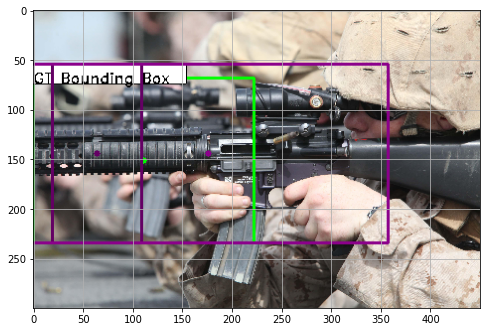

In [26]:
print('Original image: height=%d width=%d' % (image_data['height'], image_data['width']))
print('Resized image: height=%d width=%d C.im_size=%d' % (X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d' % (Y[0].shape[1], Y[0].shape[2], C.rpn_stride))

print(X.shape)

print(str(len(Y)) +" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))

if debug_num_pos == 0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1'] * (X.shape[2] / image_data['height']), image_data['bboxes'][0]['x2'] * (X.shape[2] / image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1'] * (X.shape[1] / image_data['width']), image_data['bboxes'][0]['y2'] * (X.shape[1] / image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)

    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1 - 5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1 + gt_x2) / 2), int((gt_y1 + gt_y2) / 2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()

else:
    cls = Y[0][0]
    pos_cls = np.where(cls == 1)
    print(pos_cls)

    regr = Y[1][0]
    pos_regr = np.where(regr == 1)
    print(pos_regr)

    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0], pos_cls[1][0], :]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0], pos_regr[1][0], :]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1'] * (X.shape[2] / image_data['width']), image_data['bboxes'][0]['x2'] * (X.shape[2] / image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1'] * (X.shape[1] / image_data['height']), image_data['bboxes'][0]['y2'] * (X.shape[1] / image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1 + gt_x2) / 2), int((gt_y1 + gt_y2) / 2)), 3, color, -1)

    textLabel = 'GT Bounding Box'
    (retval,baseLine) = cv2.getTextSize(textLabel, cv2.FONT_HERSHEY_COMPLEX, 0.5, 1)
    textOrg = (gt_x1, gt_y1 + 5)

    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):
        color = (100 + i * (155 / 4), 0, 100 + i * (155 / 4))

        idx = pos_regr[2][i * 4] / 4
        anchor_size = C.anchor_box_scales[int(idx / 3)]
        anchor_ratio = C.anchor_box_ratios[2 - int((idx + 1) % 3)]

        center = (pos_regr[1][i * 4] * C.rpn_stride, pos_regr[0][i * 4] * C.rpn_stride)
        print('Center position of positive anchor: ', center)

        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size * anchor_ratio[0], anchor_size * anchor_ratio[1]
        cv2.rectangle(img, (center[0] - int(anc_w / 2), center[1] - int(anc_h / 2)), (center[0] + int(anc_w / 2), center[1] + int(anc_h / 2)), color, 2)

print('Green box is ground-truth box. Others are positive anchors')
plt.figure(figsize=(8, 8))
plt.grid()
plt.imshow(img)
plt.show()

### Build the Model

In [27]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

img_input = tf.cast(img_input, dtype='float64')

shared_layers = nn_base(img_input, trainable=True)

In [28]:
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) 

rpn = rpn_layer(shared_layers, num_anchors)
classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[: 2])
model_classifier = Model([img_input, roi_input], classifier)

# model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[: 2] + classifier)

# save the model and load the model to continue training in case it is interrupted
if not os.path.isfile(C.model_path):
    try:
        print('Loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])

else:
    print('Continue training based on previously trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already trained %dK batches'% (len(record_df)))

Loading weights from drive/My Drive/AI/RPN/model/vgg_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder https://github.com/fchollet/keras/tree/master/keras/applications


In [29]:
optimizer = Adam(learning_rate=1e-5)
optimizer_classifier = Adam(learning_rate=1e-5)

model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count) - 1)], metrics={'dense_class_{}'.format(len(classes_count)) : 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

### Train Model

In [30]:
total_epochs = len(record_df)
r_epochs = len(record_df)

iters_per_epoch = 10
num_epochs = 4
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((iters_per_epoch, 5))

rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df) == 0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [31]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(iters_per_epoch)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:
            if len(rpn_accuracy_rpn_monitor) == total_epochs and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor)) / len(rpn_accuracy_rpn_monitor)

                rpn_accuracy_rpn_monitor = []
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)
            X = tf.cast(X, dtype='float64')
            
            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4 // 2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois // 2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # In the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()

                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == iters_per_epoch:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time) / 60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}; Saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            continue

print('Training complete, exiting.')

Epoch 1/4
10/10 [==============================] - 183s 18s/step - rpn_cls: 7.3973 - rpn_regr: 0.6653 - final_cls: 2.3979 - final_regr: 0.4966
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.6875
Classifier accuracy for bounding boxes from RPN: 0.425
Loss RPN classifier: 7.302873706817627
Loss RPN regression: 0.5736750666052103
Loss Detector classifier: 2.397860860824585
Loss Detector regression: 0.503756308555603
Total loss: 10.778165942803025
Elapsed time: 183.4925594329834
Total loss decreased from inf to 10.778165942803025; Saving weights
Epoch 2/4
10/10 [==============================] - 139s 14s/step - rpn_cls: 7.0356 - rpn_regr: 0.1284 - final_cls: 2.3978 - final_regr: 0.5473
Mean number of bounding boxes from RPN overlapping ground truth boxes: 3.5
Classifier accuracy for bounding boxes from RPN: 0.525
Loss RPN classifier: 6.955000019073486
Loss RPN regression: 0.15175989344716073
Loss Detector classifier: 2.3977155685424805
Loss Detector regression: 0.

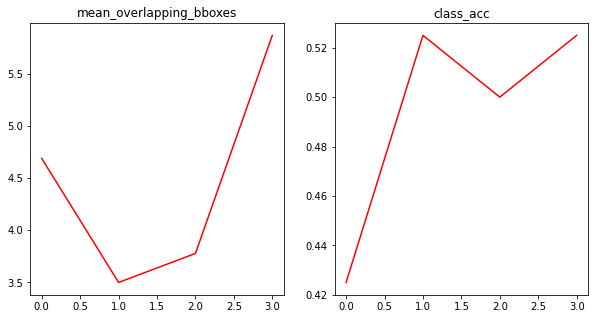

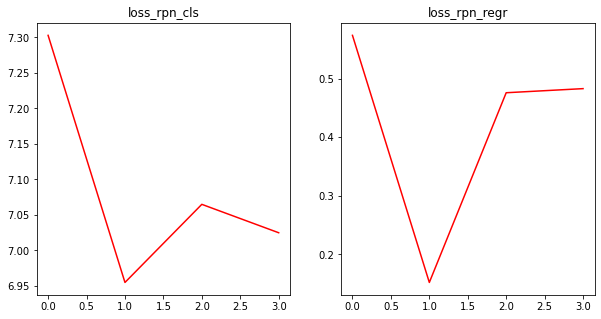

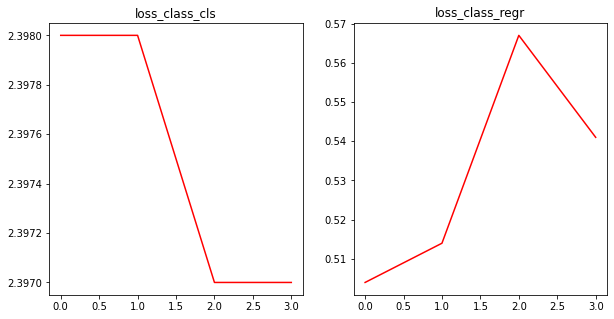

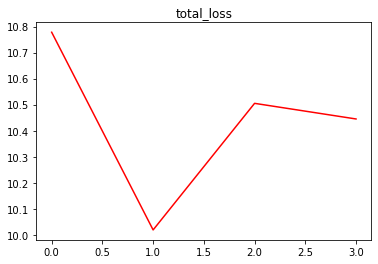

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

## Testing

In [33]:
test_base_path = 'drive/MyDrive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
test_annotation_path = 'drive/MyDrive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test_annotation.txt'

### Format the Image

In [34]:
def format_img_size(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side / width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
  
	else:
		ratio = img_min_side / height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
  
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
 
	return img, ratio	

def format_img_channels(img, C):
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
 
	return img

def format_img(img, C):
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
 
	return img, ratio

def get_real_coordinates(ratio, x1, y1, x2, y2):
	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

### Compile Model and Load Weights

In [35]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

shared_layers = nn_base(img_input, trainable=True)

num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from drive/My Drive/AI/RPN/model/model_vgg.hdf5


In [36]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}

print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Tool', 1: 'Shotgun', 2: 'Human nose', 3: 'Fire hydrant', 4: 'Whisk', 5: 'Scale', 6: 'Musical instrument', 7: 'Whiteboard', 8: 'Light switch', 9: 'Toaster', 10: 'bg'}


In [37]:
test_imgs = os.listdir(test_base_path)

imgs_path = []

for i in range(len(test_imgs)):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

### Start Testing

1a18d59963dcd4d4.jpg
Elapsed time = 15.981602430343628
[]


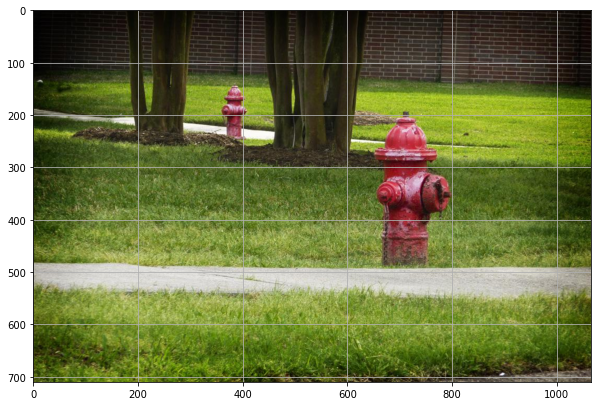

1a18d59963dcd4d4.jpg
Elapsed time = 15.026827335357666
[]


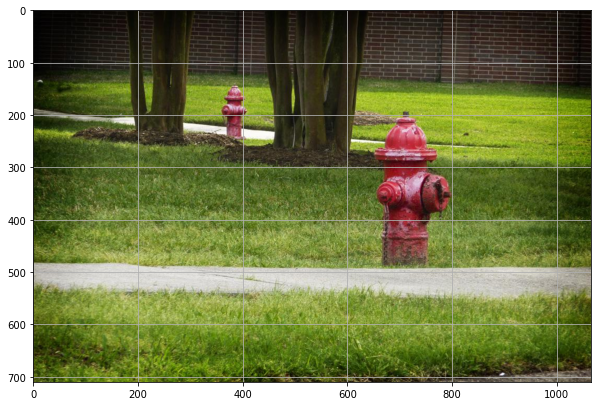

801a521d3e637752.jpg
Elapsed time = 15.511705160140991
[]


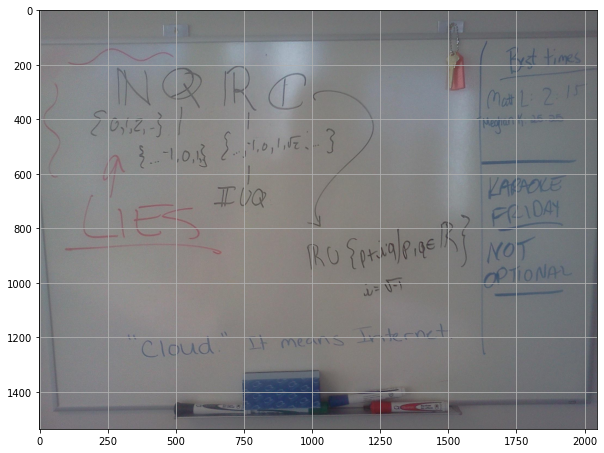

0498e6dffb2e773d.jpg
Elapsed time = 17.0426607131958
[]


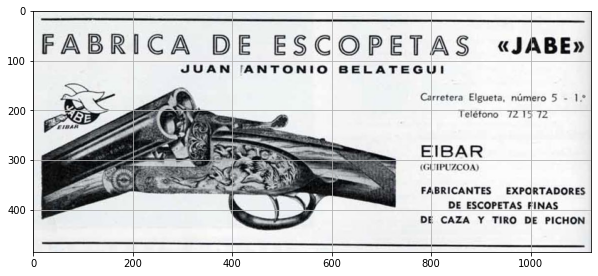

658dc8d9e2994435.jpg
Elapsed time = 15.038147687911987
[]


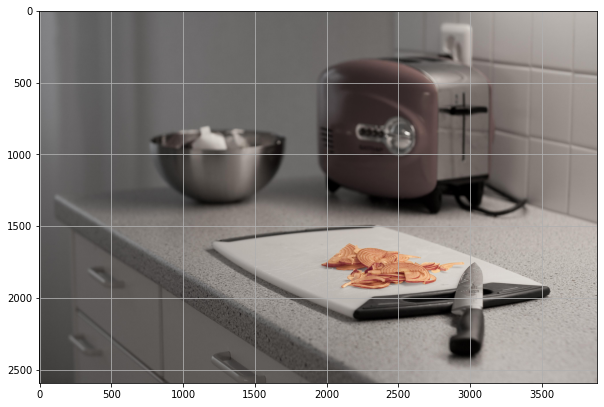

1a18d59963dcd4d4.jpg
Elapsed time = 15.245573282241821
[]


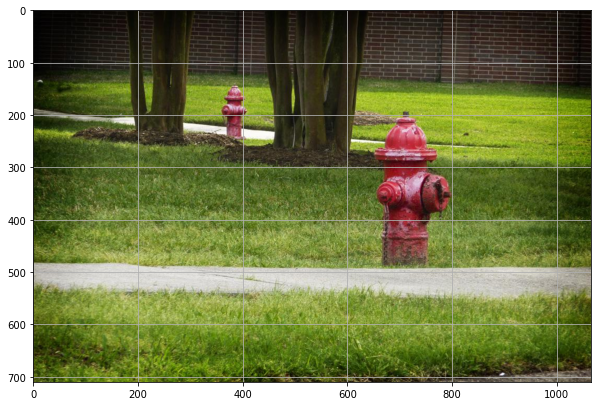

62a5425ce90220fc.jpg
Elapsed time = 14.680188655853271
[]


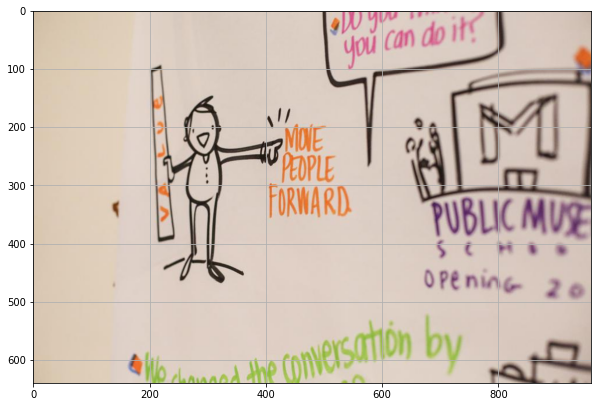

1bf2a196a3485be6.jpg
Elapsed time = 14.49120044708252
[]


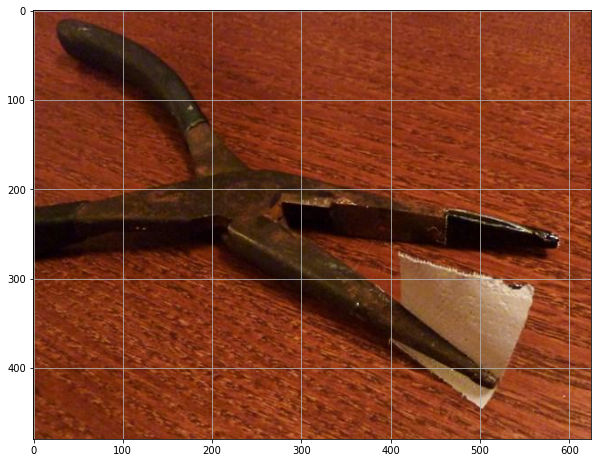

658dc8d9e2994435.jpg
Elapsed time = 14.494893312454224
[]


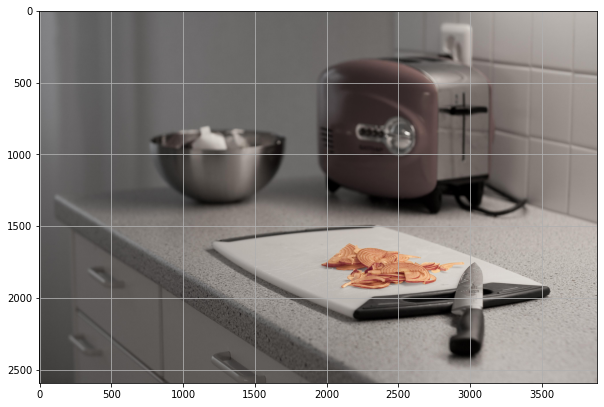

0498e6dffb2e773d.jpg
Elapsed time = 17.913752555847168
[]


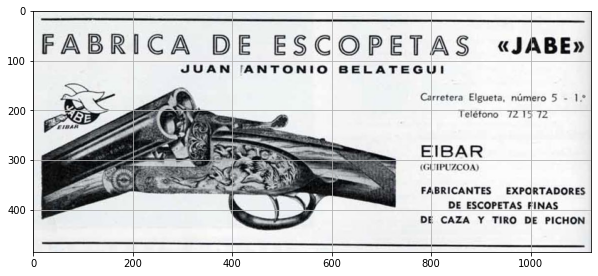

581df50df70ea9da.jpg
Elapsed time = 14.694206476211548
[]


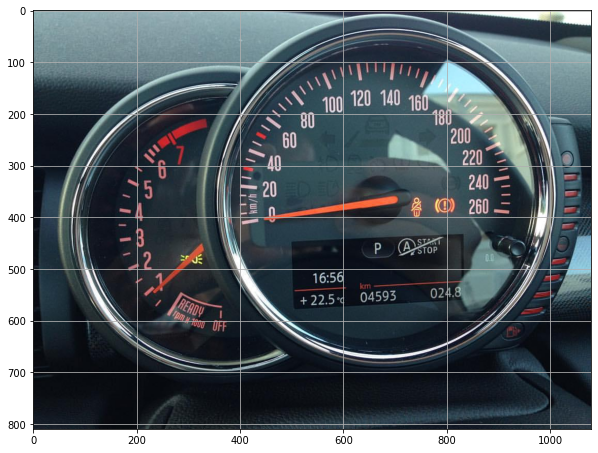

1a18d59963dcd4d4.jpg
Elapsed time = 14.38049840927124
[]


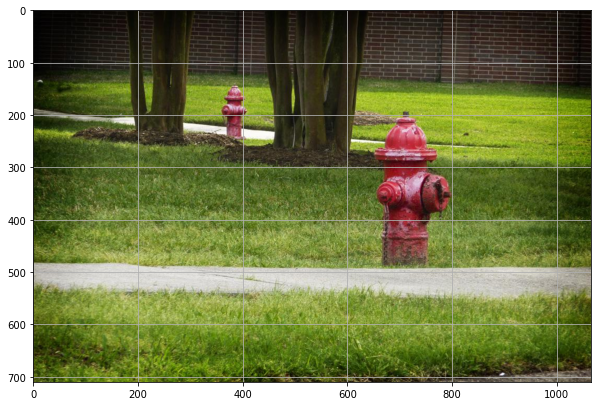

In [38]:
bbox_threshold = 0.5

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue

    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)
    X, ratio = format_img(img, C)
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS; R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk : C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])

            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num : 4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)

            except:
                pass

            bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])), 4)

            textLabel = '{}: {}'.format(key,int(100 * new_probs[jk]))
            all_dets.append((key,100 * new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX, 1, 1)
            textOrg = (real_x1, real_y1 - 0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

In [39]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']

		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']

		pred_prob = pred_box['prob']

		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []

		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1'] / fx
			gt_x2 = gt_box['x2'] / fx
			gt_y1 = gt_box['y1'] / fy
			gt_y2 = gt_box['y2'] / fy

			gt_seen = gt_box['bbox_matched']

			if gt_class != pred_class:
				continue

			if gt_seen:
				continue

			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
   
			if iou_map >= 0.5:
				found_match = True

				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	return T, P

### mAP

In [40]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size 
	Args:
		img: cv2 image
		C: config
	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling"""

	img_min_side = float(C.im_size)
	(height, width,_) = img.shape
	
	if width <= height:
		f = img_min_side / width
		new_height = int(f * height)
		new_width = int(img_min_side)
  
	else:
		f = img_min_side / height
		new_width = int(f * width)
		new_height = int(img_min_side)
  
	fx = width / float(new_width)
	fy = height / float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
 
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor

	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
 
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [41]:
test_imgs, _, _ = get_data(test_annotation_path)

In [42]:
T = {}
P = {}
mAPs = []

for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx, len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)
    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        for ii in range(P_cls.shape[1]):
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])

            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]

                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]

                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)

            except:
                pass

            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)

        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)

    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))

    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])

    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)

    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    
print()
print('Mean Average Precision:', np.mean(np.array(mAPs)))

0/12
Elapsed time = 14.29781436920166
Tool AP: 1.0
mAP = 1.0
1/12
Elapsed time = 14.37765622138977
Tool AP: 1.0
Whisk AP: 1.0
mAP = 1.0
2/12
Elapsed time = 14.09811520576477
Tool AP: 1.0
Whisk AP: 1.0
mAP = 1.0
3/12
Elapsed time = 14.155096769332886
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
mAP = 1.0
4/12
Elapsed time = 14.997706174850464
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
mAP = 1.0
5/12
Elapsed time = 14.174973249435425
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
Whiteboard AP: 1.0
mAP = 1.0
6/12
Elapsed time = 14.504876136779785
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
Whiteboard AP: 1.0
Human nose AP: 1.0
mAP = 1.0
7/12
Elapsed time = 15.282272338867188
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
Whiteboard AP: 1.0
Human nose AP: 1.0
Shotgun AP: 1.0
mAP = 1.0
8/12
Elapsed time = 14.528039455413818
Tool AP: 1.0
Whisk AP: 1.0
Fire hydrant AP: 1.0
Whiteboard AP: 1.0
Human nose AP: 1.0
Shotgun AP: 1.0
Toaster AP: 1.0
mAP = 1.0
9/12
Elapsed time = 14.329

In [43]:
mAP = [mAP for mAP in mAPs if str(mAP) != 'nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)

print('After training %d batches, the mean average precision is %0.3f' % (len(record_df) * 10, mean_average_prec))

After training 40 batches, the mean average precision is 1.000
